In [201]:
import numpy as np
import pandas as pd
import operator
import collections
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## Load data

In [498]:
X = pd.read_csv('./hw2-data/Bayes_classifier/X.csv', header = None)
y = pd.read_csv('./hw2-data/Bayes_classifier/y.csv', header = None)

## Implement Naive Bayes

Data: $ y_i \approx Bern(\pi)$

$x_{i,d} \mid y_i \approx Pois(\lambda_{y_i,d}), d = 1,..., D$

Prior: $\lambda_{y,d} \approx Gamma(2,1)$

Prediction: $y_0 = argmax \space p(y_0 = y \mid \pi) \prod_{d=1}^D p(x_{0,d} \mid \lambda_{y,d})$

$y_0 = argmax_{y \in Y} \space \hat{\pi_{y}}\prod_{d=1}^D \frac{\lambda^{x_0}e^{-\lambda}}{x_0!}$

Taking log: $y_0 = argmax \space ln(\hat{\pi_{y}}) + \sum_{d=1}^D x_{0,d} ln(\hat{\lambda}) - \hat{\lambda}$ (we remove the factorial term as it does not matter here)

Results from question 1:

$\hat{\pi} = \frac{\sum(y_i)}{n}$

$\hat{\lambda} = \frac{1 + \sum x_{i,d} \mathbb{1}\{y_i = y\}}{1 + \sum \mathbb{1}\{y_i = y\}}$

In [179]:
# observations in class y over # observations in total
def get_prior(y):
    rst = {}
    cnt = collections.Counter(np.squeeze(np.asarray(y)))
    total = y.shape[0]
    
    for i in np.unique(y):
        rst[i] = cnt[i]/total
    
    return rst

In [329]:
# answer to 1b
def pois_mle(x, y, y_tar, d):
    
    idx = np.where(y == y_tar)[0]
    
    sum_x = x[:, d][idx].sum()
    N_y = idx.shape[0]
    
#     for i in range(x.shape[0]):
#         if y[i] == y_tar:
#             N_y += 1
#             sum_x += x.T[d][i]
    
    return (1+sum_x)/(1+N_y)

In [321]:
# we use the result after taking log
def get_likelihood(param, d, x):
    # d = dimension
    # param = poisson mle
    rst = x[d] * np.log(param) - param
    
    return rst
    

In [332]:
def get_pred(x, x_t, y):
    D = x.shape[1]
    prior = get_prior(y)
    #print(prior)
    
    prev = np.ones(2)
    
    # for each y (also the y_target)
    for i in np.unique(y):
        total = 0
        for d in range(D):
            lmda = pois_mle(x, y, i, d)
            #print(lmda)
            
            likelihood = get_likelihood(lmda, d, x_t)
            
            
            total = total + likelihood
        
        prev[i] = total + np.log(prior[i])
        
    prediction = prev.argmax()
    
    return prediction

In [503]:
X = X.to_numpy()
y = y.to_numpy()

In [333]:
start_time = time.time()
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

TP = 0
FN = 0
FP = 0
TN = 0

for train_idx, test_idx in kf.split(X, y):

    for i in range(X[test_idx].shape[0]):
        
        t = y[test_idx][i]
        pred = get_pred(X[train_idx], X[test_idx][i], y[train_idx])
        
        if t == 1 and pred == 1:
            TP += 1
        if t == 0 and pred == 1:
            FP += 1
        if t == 1 and pred == 0:
            FN += 1
        if t == 0 and pred == 0:
            TN += 1  

print("--- %s seconds ---" % (time.time() - start_time))

--- 26.97141408920288 seconds ---


In [238]:
TP_s = TP
FP_s = FP
FN_s = FN
TN_s = TN

In [334]:
rst = pd.DataFrame(index = ['pred_1', 'pred_0'], columns = ['y_1', 'y_0'])

In [335]:
rst.iloc[0,0] = TP
rst.iloc[0,1] = FP
rst.iloc[1,0] = FN
rst.iloc[1,1] = TN

In [336]:
rst

,y_1,y_0
pred_1,1714,492
pred_0,99,2295


In [337]:
acc = (TP + TN)/(TP + FP + FN + TN)
acc

0.8715217391304347

## Stem plot

In [338]:
def get_lamdals(x, x_t, y):
    D = x.shape[1]
    prior = get_prior(y)
    #print(prior)
    
    prev = np.ones(2)
    
    lmda_ls_0 = []
    lmda_ls_1 = []
    
    # for each y (also the y_target)
    for i in np.unique(y):
        total = 0
        for d in range(D):
            lmda = pois_mle(x, y, i, d)
            
            if i == 0:
                lmda_ls_0.append(lmda)
            if i == 1:
                lmda_ls_1.append(lmda)
    
    return lmda_ls_0, lmda_ls_1

In [340]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

In [348]:
len(param_ls_1)

1

In [350]:
start_time = time.time()

param_ls_0 = []
param_ls_1 = []
    
for train_idx, test_idx in kf.split(X, y):

    for i in range(X[test_idx].shape[0]):
        
        t = y[test_idx][i]
        ls0, ls1 = get_lamdals(X[train_idx], X[test_idx][i], y[train_idx])
    
    param_ls_0.append(ls0)
    param_ls_1.append(ls1)
        
param_0 = np.array(param_ls_0)
param_1 = np.array(param_ls_1)
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 27.911426067352295 seconds ---


In [362]:
mean_0 = []
mean_1 = []

for i in range(param_0.shape[1]):
    mean_0.append(param_0[:,i].mean())
    mean_1.append(param_1[:,i].mean())


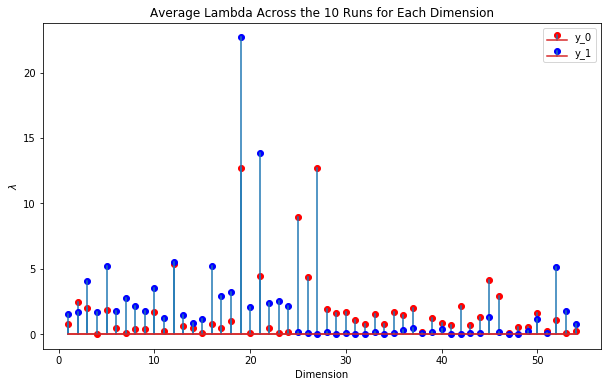

In [387]:
fig, ax = plt.subplots(1,1, figsize = (10, 6))

ax.stem(range(1,param_0.shape[1]+1), mean_0, markerfmt = 'ro', label = 'y_0');
ax.stem(range(1,param_0.shape[1]+1), mean_1, markerfmt = 'bo', label = 'y_1');
ax.set_xlabel('Dimension');
ax.set_ylabel('$\lambda$');
ax.set_title('Average Lambda Across the 10 Runs for Each Dimension');
ax.legend();
fig.savefig('2b');



## $d_{16}$ is 'free' and $d_{52}$ is '!'. They both have higher lambda for y when y = 1, than when y = 0. This seems to suggest that emails with 'free' and '!' are likely to be spam emails.

## Implement k-NN

In [228]:
# define distance function
# here we are using l1 distance
def l1_distance(v1, v2):
    return np.sum(np.abs(v1 - v2))

In [552]:
X.shape

(4600, 54)

In [556]:
# store all the distances
neighbors_list = []
for i in range(X.shape[0]):
    distance = []
    neighbors = []
    for j in range(X.shape[0]):
        if i == j:
            continue
        else:
            dist = l1_distance(X[i], X[j])
            distance.append((j, dist)) 
    
    distance.sort(key = operator.itemgetter(1))
    
    for k_i in range(X.shape[0]-1):
        neighbors.append(distance[k_i][0])
            
    neighbors_list.append(neighbors)

In [533]:
neighbors_list[0].shape

(20,)

In [836]:
# return the majority-vote to predict
def predict_knn(knn, y_train):
    
    vote = []
    
    for i in range(knn.shape[0]):
        #print(y_train[i])
        vote.append(y_train[i][0])
        #print(111111)
        #print(sum(vote))
        #print(len(vote))
    
    # calculate majority
    chance = sum(vote)/len(vote)
    if chance > 0.5:
        return 1
    else:
        return 0

In [827]:
def accuracy(pred, y_test):
    #y_test = np.squeeze(y_train.to_numpy())
    count = 0
    for idx in range(len(pred)):
        if pred[idx] == y_test[idx]:
            count += 1
    
    return count/len(pred)

In [828]:
neighbors_list = np.asarray(neighbors_list)

In [829]:
start_time = time.time()
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

In [837]:
acc = []
for train_idx, test_idx in kf.split(X, y):
    t_id = test_idx.tolist()
    #print(t_id)
    # we first remove all train in knn
    # i.e., we only want the knn for each test id
    knn = neighbors_list[test_idx]

    y_train = y[train_idx]
    y_test = y[test_idx]
    
    y_train = np.squeeze(y_train)
    y_test = np.squeeze(y_test)
    
    k_acc = []
    for k in range(1, 21):
        pred = []
        
        # then for every test id knn
        # we remove all other test id in knn
        # i.e., we take all the train id
        # get top k list
        for i in range(X_test.shape[0]):
            top_k = []
            k_id = knn[i]
            
            count = 0
            for j in range(k_id.shape[0]):
                if k_id[j] not in test_idx:
                    top_k.append(k_id[j])
                    count += 1
                    
                    if count == k:
                        break
                else:
                    continue
        
            top_k = np.asarray(top_k)
            #print(top_k)
            y_idx = y[top_k]
        #print(y_idx)

            pred.append(predict_knn(top_k, y_idx))
            #print(pred)
        
        k_acc.append(accuracy(pred, y_test))
        
    acc.append(k_acc)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1336.2265720367432 seconds ---


In [838]:
acc = np.asarray(acc)

In [839]:
rst = np.mean(acc, axis = 0)

In [840]:
rst

array([0.88630435, 0.87195652, 0.8826087 , 0.88217391, 0.88826087,
       0.88195652, 0.88391304, 0.88021739, 0.87913043, 0.88804348,
       0.88934783, 0.905     , 0.90717391, 0.90673913, 0.9073913 ,
       0.90456522, 0.90695652, 0.90391304, 0.90347826, 0.89978261])

In [841]:
x = [*range(1,21,1)]

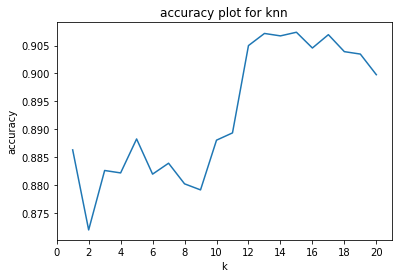

In [842]:
plt.plot(x,rst);
plt.xticks([0,2,4,6,8,10,12,14,16,18,20]);
plt.xlabel('k');
plt.ylabel('accuracy');
plt.title('accuracy plot for knn');
plt.savefig('2c')

# Problem 3

## Implement Gaussian process

In [391]:
X_train = pd.read_csv('./hw2-data/Gaussian_process/X_train.csv', header = None)
X_test = pd.read_csv('./hw2-data/Gaussian_process/X_test.csv', header = None)
y_train = pd.read_csv('./hw2-data/Gaussian_process/y_train.csv', header = None)
y_test = pd.read_csv('./hw2-data/Gaussian_process/y_test.csv', header = None)

In [392]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## Write code and make prediction on test set

In [198]:
def kernel(b, x1, x2):
    dist = np.sum(x1**2, 1).reshape(-1,1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    
    return np.exp(-dist/b)

In [199]:
# the prediction
def expectation(b, sig2, x_new, x, y):

    # K(X,X)
    K_n = kernel(b, x, x)
    
    m_inv = sig2*np.eye(len(x))
    
    K_inv = np.linalg.inv(K_n + m_inv)
    
    # K(X,x_0)
    K_xd = kernel(b, x, x_new)
    
    return np.dot(np.dot(K_xd.T, K_inv), y)

## For $b \in \{5, 7, 9, 11, 13, 15\}$ and $\sigma^2 \in \{.1, .2, .3, .4, .5, .6, .7, .8, .9, 1\}$

In [200]:
def get_rmse(test, pred):
    rmse = np.sqrt(np.sum(np.square(test - pred))/len(test))
    #print(rmse)
    return rmse

In [201]:
b_ls = [5, 7, 9, 11, 13, 15]
sig_ls = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]

rst_matrix = pd.DataFrame(index = b_ls, columns = sig_ls)

for b in b_ls:
    for sig2 in sig_ls:
        mean = expectation(b, sig2, X_test, X_train, y_train)
        rmse = get_rmse(y_test, mean)
        rst_matrix.loc[b,sig2] = rmse
        

In [202]:
rst_matrix

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
5,1.96628,1.93314,1.92342,1.9222,1.92477,1.92921,1.93464,1.94059,1.94682,1.95321
7,1.92016,1.90488,1.90808,1.9159,1.92481,1.9337,1.94226,1.95038,1.9581,1.96544
9,1.89765,1.90252,1.91765,1.93252,1.9457,1.95724,1.96741,1.97649,1.98474,1.99234
11,1.89051,1.91498,1.93885,1.95794,1.97322,1.98577,1.99638,2.00561,2.01384,2.02135
13,1.89585,1.93559,1.9646,1.9855,2.00132,2.01388,2.02431,2.03331,2.04132,2.04864
15,1.90961,1.95955,1.99081,2.01192,2.02737,2.03947,2.04947,2.05811,2.06585,2.07298


## The best value is 1.89 when b = 11, $\sigma^2 = 0.1$; the result is better than the first homework (around 2.2). The drawback might be the computation time. We are inverting nxn matrix here whereas in hw1 we are inverting dxd matrix. Thus, if n grows, computation might become expensive. Also feature selection is easier and more intuitive with ridge regression as compared to here.

## Only the 4th dimension; b = 5, $\sigma^2 = 2$

In [310]:
X_train = pd.read_csv('./hw2-data/Gaussian_process/X_train.csv', header = None)
X_test = pd.read_csv('./hw2-data/Gaussian_process/X_test.csv', header = None)
y_train = pd.read_csv('./hw2-data/Gaussian_process/y_train.csv', header = None)
y_test = pd.read_csv('./hw2-data/Gaussian_process/y_test.csv', header = None)

In [311]:
x_d = X_train.loc[:,3].to_numpy().reshape(-1, 1)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

mean_d = expectation(5, 2, x_d, x_d, y_train)

In [326]:
idx = np.argsort(x_d.flatten())

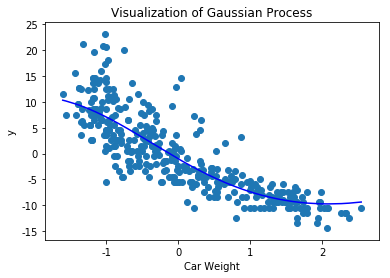

In [329]:
plt.plot(x_d.flatten()[idx], mean_d.flatten()[idx], 'b-');
plt.scatter(x_d, y_train);
plt.xlabel('Car Weight');
plt.ylabel('y');
plt.title('Visualization of Gaussian Process');
plt.savefig('3d')